In [8]:
import os
import io
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import cv2

from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

print("Setup complete")

Setup complete


In [9]:
ROOT_DIR = "dataset/fruit360"
TEST_DIR = os.path.join(ROOT_DIR, "Test")
CKPT_ROOT = Path("artifacts/checkpoints")

SIZE = 32
COLOR_BINS = 16
VARIETY = False

class FruitFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            label = class_name if self.variety else class_name.split()[0]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for lbl, i in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label_to_idx[label_str]

transform_base = T.Compose([
    T.Resize((SIZE, SIZE)),
    T.ToTensor(),
])

test_dataset = FruitFolderDataset(TEST_DIR, transform=transform_base, variety=VARIETY)

print(f"Test dataset loaded: {len(test_dataset)} images")
print(f"Number of classes: {len(test_dataset.label_to_idx)}")

Test: 43442 images, 79 classes
Test dataset loaded: 43442 images
Number of classes: 79


In [ ]:
# Load checkpoints
ckpt_model_paths = sorted(CKPT_ROOT.rglob("model.joblib"))
if not ckpt_model_paths:
    raise FileNotFoundError(f"No checkpoints found under {CKPT_ROOT}")

def infer_model_name(run_dir: Path):
    parts = run_dir.parts
    return parts[-2] if len(parts) >= 2 else "unknown"

models = {}
for model_path in ckpt_model_paths:
    run_dir = model_path.parent
    scaler_path = run_dir / "scaler.joblib"
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path) if scaler_path.exists() else None
    model_name = infer_model_name(run_dir)
    
    if model_name not in models:
        models[model_name] = []
    
    models[model_name].append({
        "run_dir": str(run_dir),
        "model": model,
        "scaler": scaler,
    })

print(f"Loaded {sum(len(v) for v in models.values())} checkpoints across {len(models)} model types")
for model_name, ckpts in models.items():
    print(f"  {model_name}: {len(ckpts)} checkpoint(s)")

Loaded 4 checkpoints across 2 model types
  knn: 2 checkpoint(s)
  svm: 2 checkpoint(s)


In [11]:
def clamp01(x):
    return torch.clamp(x, 0.0, 1.0)

# Config per le trasformazioni (modifica qui i valori)
NOISE_CONFIG = {
    "grayscale": {},
    "blur_mild": {"kernel_size": 3, "sigma": 0.5},
    "blur_medium": {"kernel_size": 5, "sigma": 1.0},
    "blur_strong": {"kernel_size": 7, "sigma": 2.0},
    "noise_mild": {"std": 0.03},
    "noise_medium": {"std": 0.07},
    "noise_strong": {"std": 0.15},
    "dark": {"factor": 0.4},
    "overexposed": {"factor": 1.8},
    "noisy_blurred": {"noise_std": 0.10, "kernel_size": 5, "sigma": 1.0}
}

# Probabilità per il test mixed (modifica qui)
MIXED_PROB_MAP = {
    "grayscale": 0.20,
    "blur_mild": 0.25,
    "blur_medium": 0.10,
    "noise_mild": 0.25,
    "noise_medium": 0.15,
    "dark": 0.10,
    "overexposed": 0.10,
    "noisy_blurred": 0.05,
}

degradations_camera = {
    "clean": lambda x: x,
    "grayscale": lambda x: x.mean(dim=0, keepdim=True).repeat(3, 1, 1),
    "blur_mild":   T.GaussianBlur(kernel_size=NOISE_CONFIG["blur_mild"]["kernel_size"], sigma=NOISE_CONFIG["blur_mild"]["sigma"]),
    "blur_medium": T.GaussianBlur(kernel_size=NOISE_CONFIG["blur_medium"]["kernel_size"], sigma=NOISE_CONFIG["blur_medium"]["sigma"]),
    "blur_strong": T.GaussianBlur(kernel_size=NOISE_CONFIG["blur_strong"]["kernel_size"], sigma=NOISE_CONFIG["blur_strong"]["sigma"]),
    "noise_mild":   lambda x: clamp01(x + torch.randn_like(x) * NOISE_CONFIG["noise_mild"]["std"]),
    "noise_medium": lambda x: clamp01(x + torch.randn_like(x) * NOISE_CONFIG["noise_medium"]["std"]),
    "noise_strong": lambda x: clamp01(x + torch.randn_like(x) * NOISE_CONFIG["noise_strong"]["std"]),
    "dark":        lambda x: clamp01(x * NOISE_CONFIG["dark"]["factor"]),
    "overexposed": lambda x: clamp01(x * NOISE_CONFIG["overexposed"]["factor"]),
    "noisy_blurred": lambda x: T.GaussianBlur(
        kernel_size=NOISE_CONFIG["noisy_blurred"]["kernel_size"],
        sigma=NOISE_CONFIG["noisy_blurred"]["sigma"]
    )(clamp01(x + torch.randn_like(x) * NOISE_CONFIG["noisy_blurred"]["noise_std"])),
}

def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(np.sqrt(patch_area * r))
        patch_w = int(np.sqrt(patch_area / r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        
        patch = out[:, top:bottom, left:right]
        blended = alpha * patch + (1 - alpha) * color
        out[:, top:bottom, left:right] = blended
    
    return clamp01(out)

def add_occlusion_patch(x, area_ratio=0.15, color=torch.tensor([0.5, 0.5, 0.5]).view(3,1,1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(np.sqrt(patch_area * r))
    patch_w = int(np.sqrt(patch_area / r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    
    patch = out[:, top:bottom, left:right]
    blended = alpha * patch + (1 - alpha) * color
    out[:, top:bottom, left:right] = blended
    
    return clamp01(out)

color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3,1,1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3,1,1)

degradations_fruit = {
    "dirty": lambda x: add_color_patches(x, num_patches=3, color=color_dirt,
                                         alpha_range=(0.5, 0.75), size_range=(0.05, 0.12)),
    "bruised": lambda x: add_color_patches(x, num_patches=2, color=color_bruise,
                                           alpha_range=(0.4, 0.7), size_range=(0.04, 0.10)),
    "occlusion": lambda x: add_occlusion_patch(x, area_ratio=0.15, alpha=0.5),
}

degradations_to_test = {**degradations_camera, **degradations_fruit}

print("Degradations defined:")
for k in sorted(degradations_to_test.keys()):
    print(f"  - {k}")

Degradations defined:
  - blur_medium
  - blur_mild
  - blur_strong
  - bruised
  - clean
  - dark
  - dirty
  - grayscale
  - noise_medium
  - noise_mild
  - noise_strong
  - noisy_blurred
  - occlusion
  - overexposed


In [12]:
def color_hist_features(X_np, bins=COLOR_BINS, img_shape=(3, 32, 32)):
    n_samples = X_np.shape[0]
    feats = np.zeros((n_samples, 3 * bins), dtype=np.float32)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    for i in range(n_samples):
        img = X_np[i].reshape(img_shape)
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0.0, 1.0)
        img_hsv = (img * 255.0).astype(np.uint8)
        img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        hists = []
        for channel in (h, s, v):
            ch_norm = channel.astype(np.float32) / 255.0
            hist, _ = np.histogram(ch_norm.ravel(), bins=bin_edges, density=True)
            hists.append(hist)
        feats[i] = np.concatenate(hists)
    return feats

def evaluate_checkpoint_on_degradation(model_obj, test_dataset, degradation_fn, degradation_name):
    """Evaluate a single checkpoint on a degraded test set"""
    model = model_obj["model"]
    scaler = model_obj["scaler"]
    
    y_true = []
    y_pred = []
    
    start_time = time.time()
    
    for img_resized, label in test_dataset:
        # Apply degradation
        img_degraded = degradation_fn(img_resized)
        
        # Convert to numpy and compute color histogram features
        img_np = img_degraded.numpy()  # (3, SIZE, SIZE)
        feats = color_hist_features(np.array([img_np]), bins=COLOR_BINS, img_shape=(3, SIZE, SIZE))
        
        # Scale features
        if scaler is not None:
            feats = scaler.transform(feats)
        
        # Predict
        pred = model.predict(feats)[0]
        y_true.append(label)
        y_pred.append(pred)
    
    elapsed = time.time() - start_time
    
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
    rec_weighted = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    result_global = {
        "model_name": "unknown",
        "degradation": degradation_name,
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "recall_macro": rec_macro,
        "recall_weighted": rec_weighted,
        "test_time_sec": elapsed,
    }
    
    results_per_class = []
    for class_idx, class_label in test_dataset.idx_to_label.items():
        class_str = str(class_idx)
        if class_str in report:
            cls_metrics = report[class_str]
            results_per_class.append({
                "model_name": "unknown",
                "degradation": degradation_name,
                "class_label": class_label,
                "f1": cls_metrics["f1-score"],
                "precision": cls_metrics["precision"],
                "recall": cls_metrics["recall"],
                "support": cls_metrics["support"],
            })
    
    return result_global, results_per_class

print("Evaluation function defined")

Evaluation function defined


In [13]:
results_global = []
results_per_class = []

print("Results storage initialized")

Results storage initialized


In [14]:
# Loop over all degradations and all checkpoints
degradations_list = sorted(degradations_to_test.keys())

for deg_idx, degradation_name in enumerate(degradations_list, 1):
    print("="*60)
    print(f"[{deg_idx}/{len(degradations_list)}] Testing: {degradation_name.upper()}")
    print("="*60)
    
    degradation_fn = degradations_to_test[degradation_name]
    
    for model_name in sorted(models.keys()):
        checkpoints = models[model_name]
        
        for ckpt_idx, model_obj in enumerate(checkpoints, 1):
            print(f"  {model_name} [{ckpt_idx}/{len(checkpoints)}]...", end=" ")
            
            try:
                result_global, result_per_class = evaluate_checkpoint_on_degradation(
                    model_obj=model_obj,
                    test_dataset=test_dataset,
                    degradation_fn=degradation_fn,
                    degradation_name=degradation_name,
                )
                
                # Add model info
                result_global["model_name"] = model_name
                result_global["checkpoint_path"] = model_obj["run_dir"]
                for r in result_per_class:
                    r["model_name"] = model_name
                    r["checkpoint_path"] = model_obj["run_dir"]
                
                results_global.append(result_global)
                results_per_class.extend(result_per_class)
                
                print(f"✓ acc={result_global['accuracy']:.4f}", end="")
                print(f" | time={result_global['test_time_sec']:.2f}s")
            except Exception as e:
                print(f"✗ Error: {e}")
    
    print()

print("\n" + "="*60)
print("All tests completed!")
print("="*60)

[1/14] Testing: BLUR_MEDIUM
  knn [1/2]... ✓ acc=0.9595 | time=119.61s
  knn [2/2]... ✗ Error: X has 48 features, but StandardScaler is expecting 16 features as input.
  svm [1/2]... ✓ acc=0.8700 | time=130.94s
  svm [2/2]... ✗ Error: X has 48 features, but StandardScaler is expecting 16 features as input.

[2/14] Testing: BLUR_MILD
  knn [1/2]... ✓ acc=0.9794 | time=107.57s
  knn [2/2]... ✗ Error: X has 48 features, but StandardScaler is expecting 16 features as input.
  svm [1/2]... ✓ acc=0.9754 | time=130.01s
  svm [2/2]... ✗ Error: X has 48 features, but StandardScaler is expecting 16 features as input.

[3/14] Testing: BLUR_STRONG
  knn [1/2]... ✓ acc=0.7770 | time=109.20s
  knn [2/2]... ✗ Error: X has 48 features, but StandardScaler is expecting 16 features as input.
  svm [1/2]... ✓ acc=0.6334 | time=129.00s
  svm [2/2]... ✗ Error: X has 48 features, but StandardScaler is expecting 16 features as input.

[4/14] Testing: BRUISED
  knn [1/2]... ✓ acc=0.9464 | time=99.90s
  knn [2/

In [21]:
print("Converting results to DataFrames...")

results_global_df = pd.DataFrame(results_global)
results_per_class_df = pd.DataFrame(results_per_class)

print(f"Global results: {len(results_global_df)} rows")
print(f"Per-class results: {len(results_per_class_df)} rows")

os.makedirs("results", exist_ok=True)
results_global_df.to_csv("results/robustness_global.csv", index=False)
results_per_class_df.to_csv("results/robustness_per_class.csv", index=False)

print("\n✓ Results saved:")
print("  - results/robustness_global.csv")
print("  - results/robustness_per_class.csv")

print("\nglobal results:")
print(results_global_df[["model_name", "degradation", "accuracy", "f1_macro", "recall_macro"]])

Converting results to DataFrames...
Global results: 28 rows
Per-class results: 2212 rows

✓ Results saved:
  - results/robustness_global.csv
  - results/robustness_per_class.csv

global results:
   model_name    degradation  accuracy  f1_macro  recall_macro
0         knn    blur_medium  0.959463  0.952132      0.955070
1         svm    blur_medium  0.870034  0.908440      0.910526
2         knn      blur_mild  0.979444  0.973080      0.972392
3         svm      blur_mild  0.975415  0.978216      0.975488
4         knn    blur_strong  0.777013  0.743094      0.758149
5         svm    blur_strong  0.633419  0.617347      0.634791
6         knn        bruised  0.946434  0.937063      0.929411
7         svm        bruised  0.935592  0.937144      0.922530
8         knn          clean  0.982344  0.977015      0.975466
9         svm          clean  0.986695  0.983784      0.981053
10        knn           dark  0.155587  0.079579      0.088255
11        svm           dark  0.141476  0.022231 

Generating bar plot: Accuracy per degradation


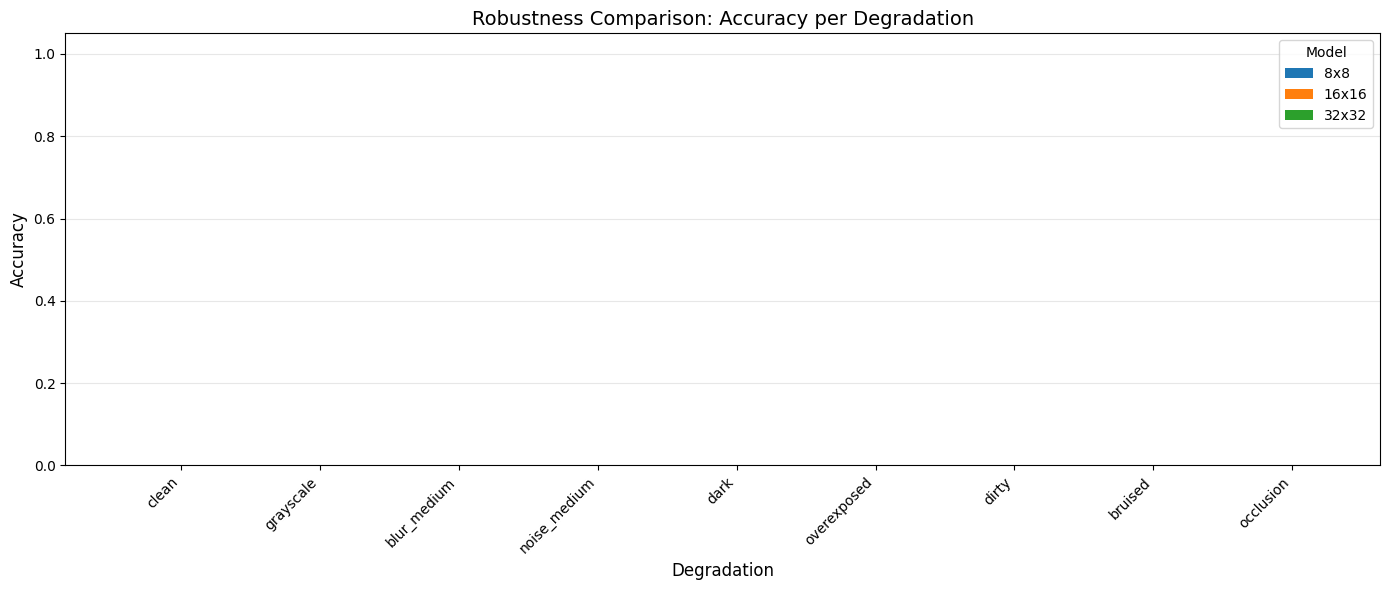

In [16]:
print("Generating bar plot: Accuracy per degradation")

degradation_order = ["clean", "grayscale", "blur_medium", "noise_medium", "dark", "overexposed", "dirty", "bruised", "occlusion"]

plot_data = results_global_df[results_global_df["degradation"].isin(degradation_order)].copy()
plot_data["degradation"] = pd.Categorical(plot_data["degradation"], categories=degradation_order, ordered=True)
plot_data = plot_data.sort_values("degradation")

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(degradation_order))
width = 0.2

models = ["8x8", "16x16", "32x32"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

for i, model_name in enumerate(models):
    model_data = plot_data[plot_data["model_name"] == model_name]
    accuracies = [model_data[model_data["degradation"] == deg]["accuracy"].values[0] if len(model_data[model_data["degradation"] == deg]) > 0 else 0 for deg in degradation_order]
    
    ax.bar(x + i*width, accuracies, width, label=model_name, color=colors[i])

ax.set_xlabel("Degradation", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Robustness Comparison: Accuracy per Degradation", fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(degradation_order, rotation=45, ha="right")
ax.set_ylim(0, 1.05)
ax.legend(title="Model", fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
print("Generating heatmap: Accuracy matrix")

pivot_acc = results_global_df.pivot(index="model_size", columns="degradation", values="accuracy")

pivot_acc = pivot_acc[degradation_order]

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(pivot_acc, annot=True, fmt=".3f", cmap="RdYlGn", cbar_kws={"label": "Accuracy"}, 
            vmin=0.7, vmax=1.0, linewidths=0.5, ax=ax)

ax.set_title("Robustness Heatmap: Accuracy by Model Size and Degradation", fontsize=14)
ax.set_xlabel("Degradation", fontsize=12)
ax.set_ylabel("Model Size", fontsize=12)

plt.tight_layout()
plt.show()

Generating heatmap: Accuracy matrix


KeyError: 'model_size'

In [18]:
print("Generating accuracy drop plot (vs clean baseline)")

clean_acc = results_global_df[results_global_df["degradation"] == "clean"].set_index("model_name")["accuracy"]

drop_data = []
for _, row in results_global_df.iterrows():
    if row["degradation"] != "clean":
        drop = row["accuracy"] - clean_acc[row["model_name"]]
        drop_data.append({
            "model_name": row["model_name"],
            "model_size": row["model_size"],
            "degradation": row["degradation"],
            "accuracy_drop": drop,
            "accuracy_drop_pct": drop * 100,
        })

drop_df = pd.DataFrame(drop_data)

pivot_drop = drop_df.pivot(index="model_size", columns="degradation", values="accuracy_drop_pct")
pivot_drop = pivot_drop[[d for d in degradation_order if d != "clean"]]

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(pivot_drop, annot=True, fmt=".1f", cmap="RdYlGn_r", center=0, 
            cbar_kws={"label": "Accuracy Drop (%)"}, linewidths=0.5, ax=ax)

ax.set_title("Accuracy Drop vs Clean Baseline (percentage points)", fontsize=14)
ax.set_xlabel("Degradation", fontsize=12)
ax.set_ylabel("Model Size", fontsize=12)

plt.tight_layout()
plt.show()

Generating accuracy drop plot (vs clean baseline)


KeyError: 'model_size'

In [19]:
print("="*60)
print("SUMMARY TABLE: Accuracy by Model and Degradation")
print("="*60)

summary = results_global_df.pivot(index="degradation", columns="model_name", values="accuracy")
summary = summary[["8x8", "16x16", "32x32"]]
summary = summary.reindex(degradation_order)

print(summary.to_string(float_format="%.4f"))

print("\n" + "="*60)
print("Mean accuracy across degradations (excluding clean):")
print("="*60)

mean_no_clean = results_global_df[results_global_df["degradation"] != "clean"].groupby("model_name")["accuracy"].mean()
print(mean_no_clean.sort_values(ascending=False).to_string(float_format="%.4f"))

SUMMARY TABLE: Accuracy by Model and Degradation


KeyError: "None of [Index(['8x8', '16x16', '32x32'], dtype='str', name='model_name')] are in the [columns]"

Per-class analysis: GRAYSCALE degradation


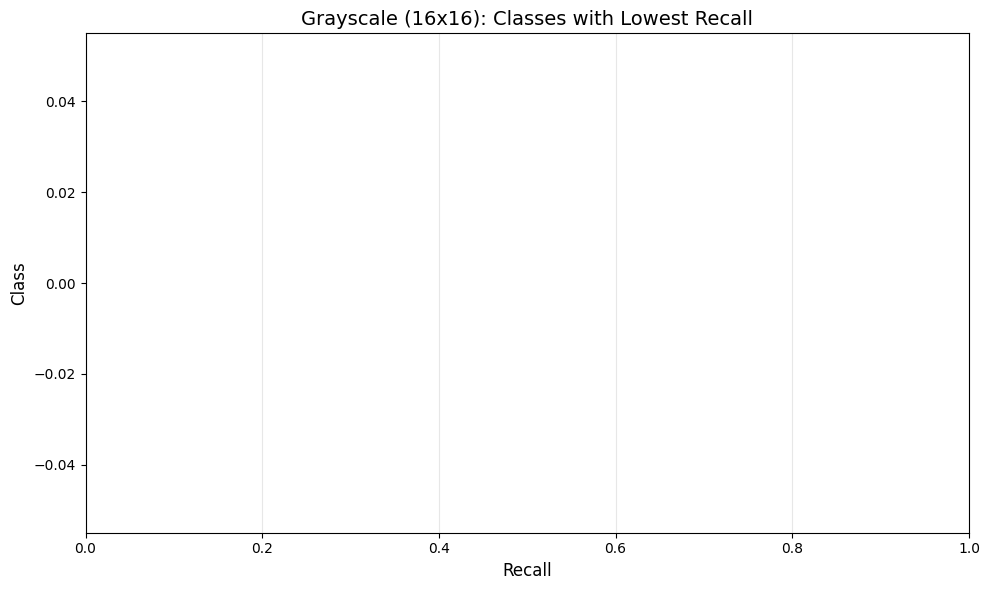


Classes most affected by grayscale (16x16 model):
Empty DataFrame
Columns: [class_label, recall, f1, support]
Index: []


In [20]:
print("Per-class analysis: GRAYSCALE degradation")

grayscale_per_class = results_per_class_df[results_per_class_df["degradation"] == "grayscale"]

model_16_gray = grayscale_per_class[grayscale_per_class["model_name"] == "16x16"].copy()
model_16_gray = model_16_gray.sort_values("recall")

bottom_10 = model_16_gray.head(10)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(bottom_10["class_label"], bottom_10["recall"], color="coral")
ax.set_xlabel("Recall", fontsize=12)
ax.set_ylabel("Class", fontsize=12)
ax.set_title("Grayscale (16x16): Classes with Lowest Recall", fontsize=14)
ax.set_xlim(0, 1)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nClasses most affected by grayscale (16x16 model):")
print(bottom_10[["class_label", "recall", "f1", "support"]].to_string(index=False))